Plots for FOOOF results fro review.

- average in 3 stages
- correlation with anatomical hierarchy
- correlations between exponential fitting and fooof (region & channel levels)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import os
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import zscore, bootstrap, ttest_rel
import matplotlib.pyplot as plt
import mne
import nibabel as nib

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Inputs:

In [3]:
inputs_file = Path(os.path.abspath("")).joinpath("inputs.yaml")
with open(inputs_file, "r") as f:
    inputs = yaml.safe_load(f)

In [4]:
res_dir_fooof = "timescales_broadband_knee_1_80"
res_dir_fit = "timescales_broadband"
fig_dir = "Figure_fooof"

Files and paths:

In [5]:
data_path = Path(inputs["base_path"])
knee_path = data_path.joinpath(inputs["results_dir"], res_dir_fooof)
fit_path = data_path.joinpath(inputs["results_dir"], res_dir_fit)
fig_path = data_path.joinpath(inputs["fig_dir"], fig_dir)
fig_path.mkdir(exist_ok=True, parents=True)

Import data:

In [6]:
stages = inputs["stages"]
df_knee_stages = {
    stage: pd.read_csv(knee_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}
for stage in stages:
    df_knee_stages[stage]["0"] = df_knee_stages[stage]["0"].apply(np.log10)

Import parcellation:

In [7]:
# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + inputs["parc_map_name"] + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", inputs["parc_map_name"], "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### 1) Average increase of timescales during sleep

Slope plot with averaged difference of timescales between wake and sleep stages across all areas of the parcellation.

diff W - N3 : 0.5987440037735893 ci [0.5817348133957071, 0.6138959764296398] pval: 9.702276414315696e-136
diff W - R : 0.14971653665570023 ci [0.13189810574412497, 0.16975388273603112] pval: 1.09147532526301e-34


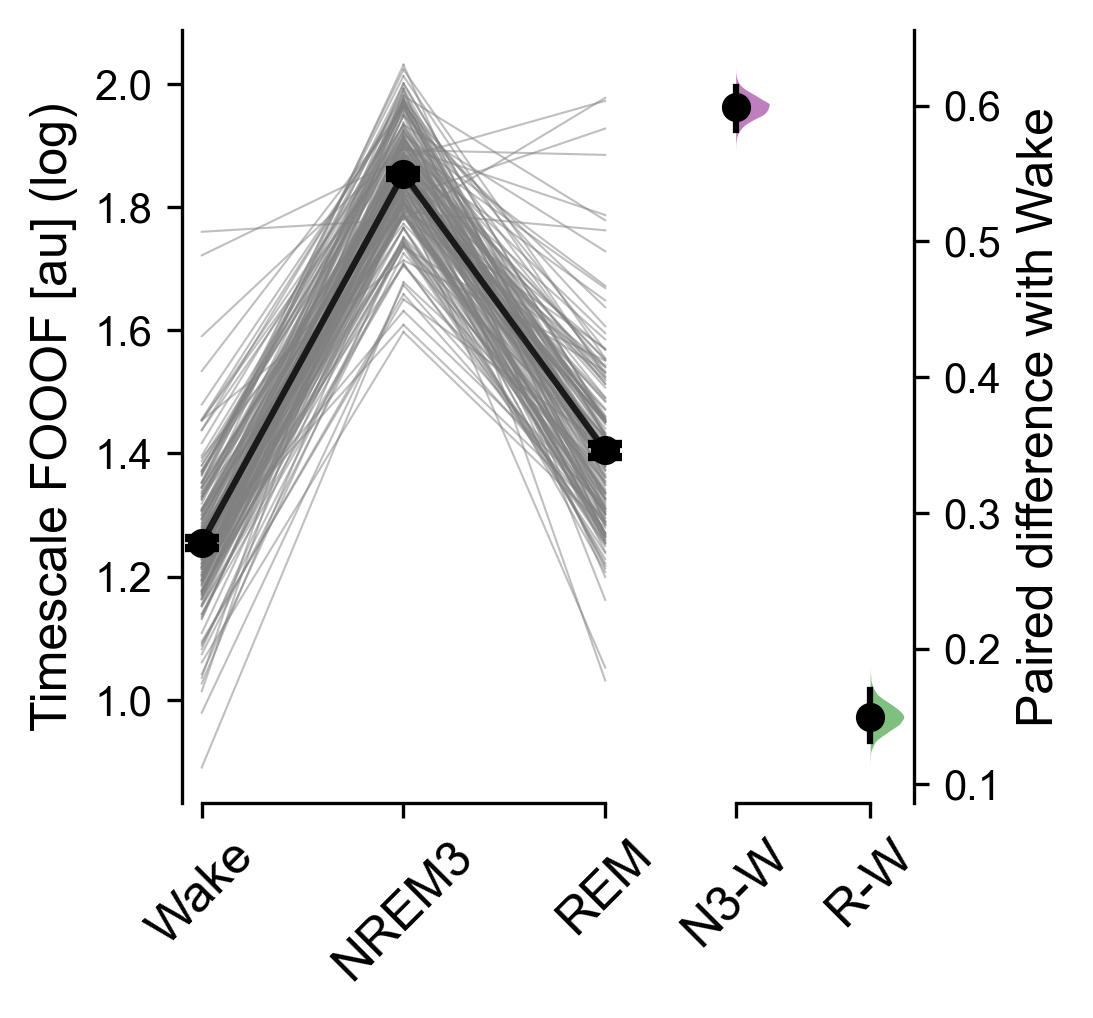

In [8]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_knee_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8., 8.5)),
    width_ratios=[2, 1],
    dpi=300,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_ylabel("Timescale FOOOF [au] (log)", fontsize=plots.fsize.LABEL_SIZE)
# y_ticks = np.array(np.linspace(0, 2.1, 5))
# axs[0].set_ylim(y_ticks[0], y_ticks[-1])
# axs[0].set_yticks(
#     y_ticks,
#     labels=10 ** y_ticks,
#     fontsize=plots.fsize.TICK_SIZE,
# )
axs[0].set_xticks(
    range(len(stages)),
    [inputs["title_dict"][stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[0], s_bounds={"bottom": (0, 2)})


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )
    print("diff W -", stage, ":", avg, "ci", list(res_boot.confidence_interval), "pval:", pval)
    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=inputs["stage_colors"][stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
# axs[1].set_ylim(0, 60)
# axs[1].set_yticks(
#     [0, 15, 30, 45, 60],
#     labels=[0, "", 30, "", 60],
#     fontsize=plots.fsize.TICK_SIZE,
# )
axs[1].set_xticks(
    range(len(stages) - 1),
    [stage + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.LABEL_SIZE,
)
plots._format_spines(axs[1], s_inv=["top", "left"], s_bounds={"bottom": (0, 1)})

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"tau_change_stages.svg"))
plt.show()

### 2) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation (for spin permutation):

In [9]:
df_struct = pd.read_csv(data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0)

In [10]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_knee_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


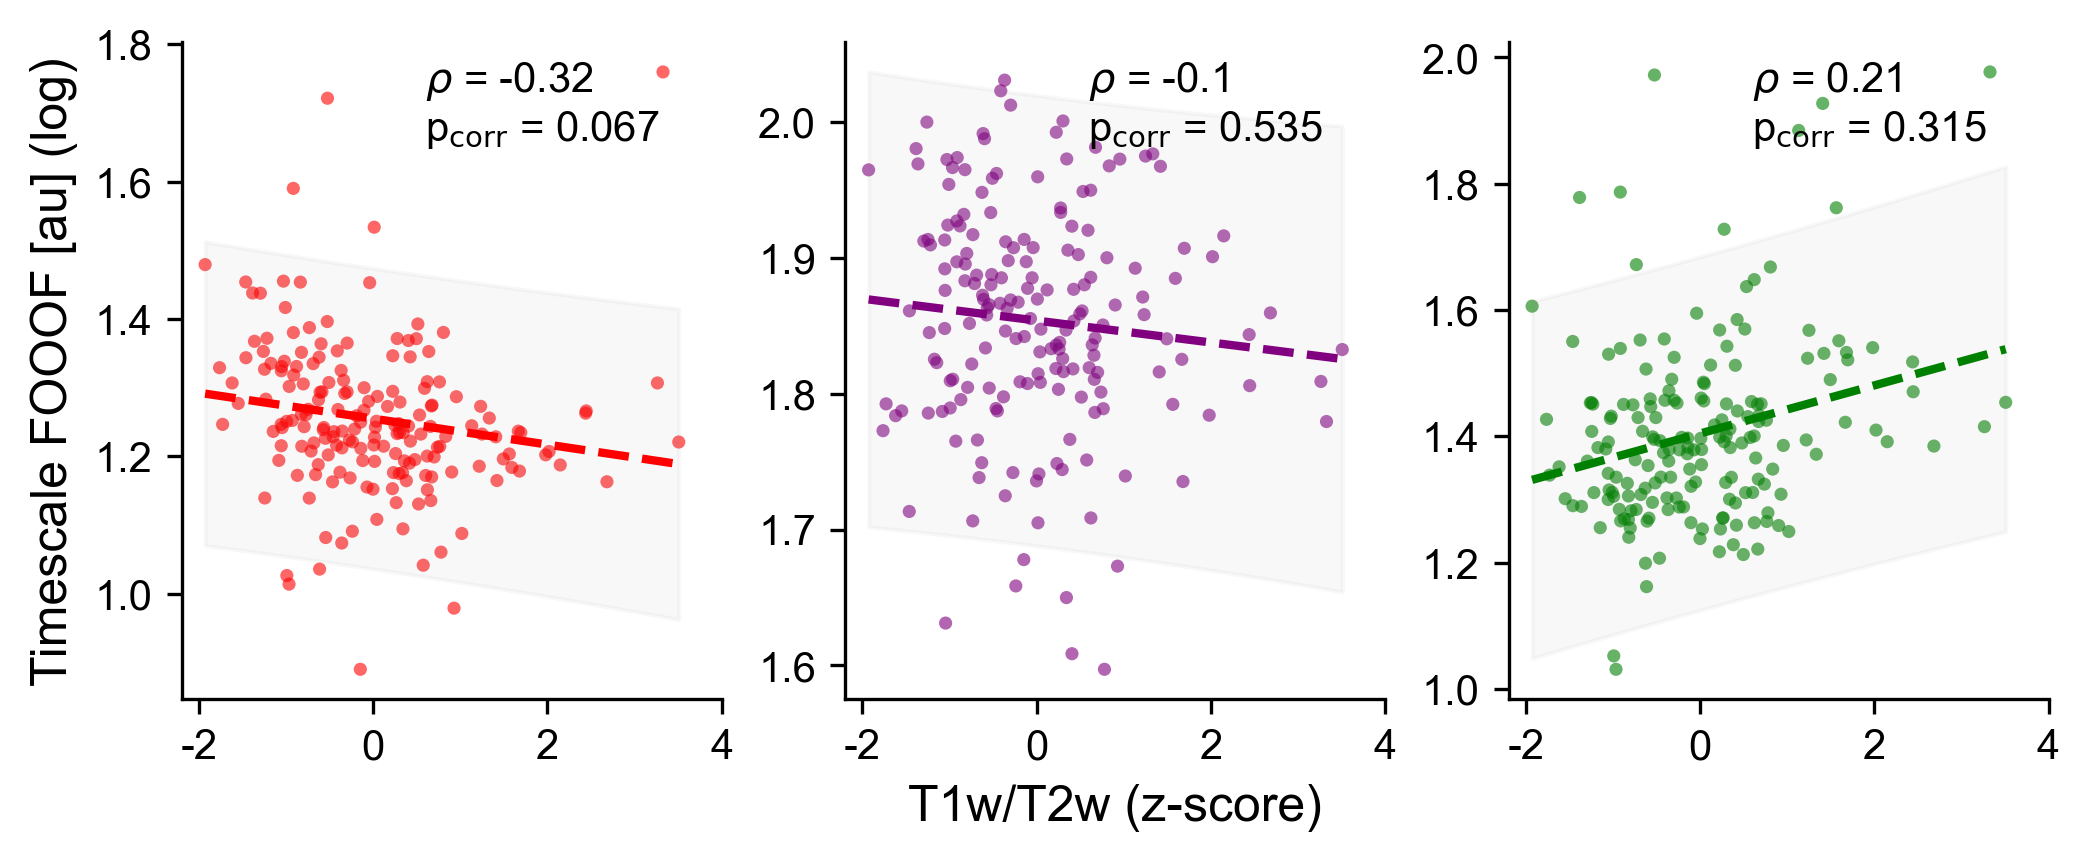

In [11]:
xlabel = "T1w/T2w (z-score)"
ylabel = "Timescale FOOOF [au] (log)"
xlims = (-2.2, 4)
xticks = [-2, 0, 2, 4]
xtick_labels = [-2, 0, 2, 4]
ylims_stages = {"W": (0, 100), "N2": (45, 125), "N3": (60, 220), "R": (20, 120)}
yticks = (
    np.arange(0, 101, 25),
    np.arange(60, 221, 40),
    np.arange(20, 121, 25)
    )
ytick_labels = (
    [0, "", 50, "", 100],
    [60, "", 140, "", 220],
    [20, "", 70, "", 120]
    )

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.4, 7)), dpi=300, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=inputs["corr_type"])
    rho_boot = utils.get_rho_boot(x, y, corr_type=inputs["corr_type"])
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=10,
        xy_annot=(0.45, 0.85),
        color=inputs["stage_colors"][stage],
        xlabel="",
        ylabel="",
        xlims=xlims,
        # ylims=ylims_stages[stage],
    )
    
    # Set ticks
    axs[i].set_xticks(xticks, labels=xtick_labels, fontsize=plots.fsize.TICK_SIZE)
    # axs[i].set_yticks(yticks[i], labels=ytick_labels[i], fontsize=plots.fsize.TICK_SIZE)
    plots._format_spines(axs[i])

# Plot customization
axs[0].set_ylabel(ylabel, fontsize=plots.fsize.LABEL_SIZE)
axs[1].set_xlabel(xlabel, fontsize=plots.fsize.LABEL_SIZE)

# Save figure
# plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))
plt.show()

### 3) Correlation between timescales with FOOOF and exponential fit

In [12]:
df_fit_stages = {
    stage: pd.read_csv(fit_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


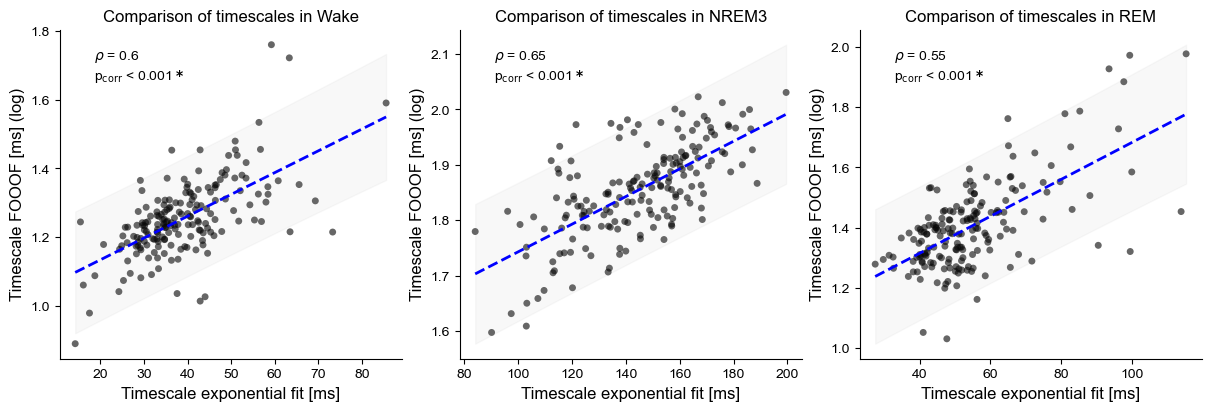

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")

for i, stage in enumerate(stages):
    x = df_fit_stages[stage].to_numpy().squeeze()
    y = df_knee_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=inputs["corr_type"])
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(4*2.4, 4*2.4),  # 2.4 is to get inches
        markersize=25,
        xy_annot=(0.1, 0.85),
        title=f"Comparison of timescales in {inputs['title_dict'][stage]}",
        xlabel="Timescale exponential fit [ms]",
        ylabel="Timescale FOOOF [ms] (log)",
    )

plt.show()

In [14]:
df_Gao = pd.read_csv(data_path.joinpath("Gao2020", "df_tau_avg.csv"), index_col=0)
df_Gao.head()

,tau,logtau
V1,17.369645,1.239791
MST,14.266527,1.154318
V6,14.733831,1.168316
V2,18.599167,1.269493
V3,17.063109,1.232058


Generating 1000 permutations...


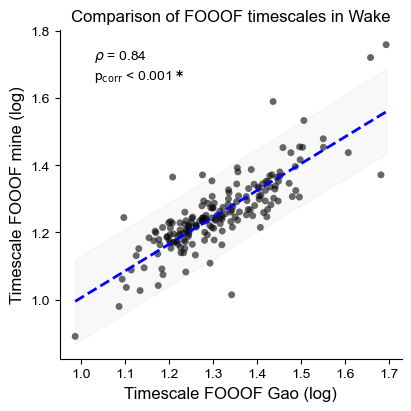

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")

x = df_Gao["logtau"].to_numpy().squeeze()
y = df_knee_stages["W"].to_numpy().squeeze()
rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=inputs["corr_type"])
ax = plots.plot_corr(
    ax,
    x,
    y,
    rho,
    p_corr,
    color_line="b",
    figsize=(4*2.4, 4*2.4),  # 2.4 is to get inches
    markersize=25,
    xy_annot=(0.1, 0.85),
    title=f"Comparison of FOOOF timescales in Wake",
    xlabel="Timescale FOOOF Gao (log)",
    ylabel="Timescale FOOOF mine (log)",
)

plt.show()